# 06 Parallel Tempering - The Hot Explorers

## A. Motivation

Recalling the [previous notebook](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/05%20Metropolis-Hastings%20Algorithm%2C%20Hills%20in%20The%20Distance.ipynb) on sampling from 3-components gaussian mixture using vanilla metropolis hastings, I'm not satisfied with the result that when one of the mode is separated by distance from other modes, the samples are not fully representative. Hence need to come up with a more sophisticated implementation of the algorithm.

After a lot of reading, I discover one of this optimization method called "tempering", inspired by physics. Even better, turns out PyMC (a very popular MCMC package) doesn't implement this method by default (yet it can generate perfect samples from our target distribution). Therefore, I am motivated to implement this algorithm and benchmark it with PyMC.

In [1]:
# packages import
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 200
import seaborn as sns
sns.set_theme(style="white")
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

## B. Tempering

In general terminology, tempering means "heat treatment". I'd like to make an analogy by borrowing context from material science. Let's take some material (an iron, whatever). Suppose we want to know all the possible properties of this material. In order to do that, we must expose the material with various environment conditions, because the material will behave differently under different environment. For instance, we can heat it up or cool it down to various temperature and at each temperature we observe the material's behavior.

Going back into statistics context, we can apply the same technique to Metropolis-Hastings. The material we want to observe the behavior of is an analogy of the target distribution we want to sample from. We will introduce a temperature parameter $T$ and let the Markov-Chain to sample from the target distribution at that temperature.

A probability distribution function with temperature parameter is called the **_"temperred form"_**. For gaussian distribution,
$$
\pi(x) \propto \exp(-f(x)) \quad \text{,} \quad f(x) = \frac{(x - \mu)^2}{2\sigma^2}
$$
the temperred form $\pi^T(x)$ at temperature $T$ is simply,
$$
\pi^T(x) \propto \exp\left(-\frac{f(x)}{T}\right) = \exp\left(-\frac{(x - \mu)^2}{2\left(\sqrt{T}\sigma\right)^2}\right)
$$
or can be written in the shorthand parametric distribution notation as,
$$
\pi^T(x) \sim \mathcal{N}\left(x | \mu, \sqrt{T}\sigma \right)
$$
As shown, it is simply scaling the $\sigma$ parameter of the Normal distribution by $\sqrt{T}$.

**Note: Temperred form of other distribution families**  
While deriving the temperred form of Gaussian is straightforward, it's not the same for other families of distributions. Especially where there are multiple shape parameters, you may not be able to do the transformation in your head, and require pen and paper.


## C. Parallel Tempering

Back to the material treatment analogy above, if our goal is just to observe the material behavior (after which we will throw away the material), it will be faster to expose the material into range of temperatures all at once (rather than one temperature at a time). One way to do it is by exposing the material to some temperature gradient. Each segment of the material will have its own temperature we can observe the behavior at.

In MCMC, the same process is done as follows;

**Step-1: Chains initialization**  
initializing $N$ Markov-Chains with target distribution $\left[ \pi^{T_1}, \pi^{T_2}, \dots, \pi^{T_N} \right]$, where $T_1 < T_2 < \dots < T_N$ , where $T_i \geq 1$ and $T_1 = 1$. 

**Step-2: Run and Swap**  
Let the chains run. After every some interval we randomly swap the state between adjacent chains. The swap is done randomly with acceptance criteria that must satisfy the [detailed balance](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/04%20Detailed%20Balance%2C%20Connecting%20Microscopic%20and%20Macroscopic%20World.ipynb) for the algorithm to be theoretically valid.

Suppose we want to do a swap between hot state $x_{i+1}$ and cold state $x_i$. The join probability before and after the swap 
- Before swap: $P_\text{before} = \pi^{T_i}(x_i) \pi^{T_{i+1}}(x_{i+1})$
- After swap: $P_\text{after} = \pi^{T_i}(x_{i+1}) \pi^{T_{i+1}}(x_{i})$

To satisfy [detailed balance](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/04%20Detailed%20Balance%2C%20Connecting%20Microscopic%20and%20Macroscopic%20World.ipynb), we can define a swap acceptance probability as $P_\text{swap} = \min[1,P_\text{after}/P_\text{before}]$. Substituting above equation, we get;
$$
P_\text{swap} = \min \left[1, \frac{\pi^{T_i}(x_{i+1}) \pi^{T_{i+1}}(x_{i})}{\pi^{T_i}(x_i) \pi^{T_{i+1}}(x_{i+1})} \right]
$$

**Step-3: Sample collection from the coldest chain ($T_1$)**  
Collecting the samples from the coldest chain equals to sample from the original target distribution because where $T_1=1$ it follows that $\pi^{T_1} = \pi$. Although we sample is drawn from the coldest chain only, the interaction (through swap) with the hotter chains has allowed even the coldest chain to explore wider landscape of the probability distribution.

**Trivia**: Paralel Tempering is widely used in biochemistry field for molecular dynamics (MD) simulation. In this field, it is more known as "Replica Exchange Model".

## D. Implementation
This algorithm is implemented in `models.mcmc.TemperredMetropolisHastings` [[source code](https://github.com/ridhoma/monte-cafe/blob/main/models/mcmc.py#L73-L144)].

Cell bellow is how we design the chains. The temperature gradient is defined as geometric series defined as 
$$
T_i = \left(T_{\text{max}}\right)^{\left(\frac{i-1}{N-1}\right)} \quad \text{,}  \quad i = 1, 2, \dots, N
$$
Through some trials and errors, I found that $T_{\text{max}} = 150$ and $N=7$ give the best fit. Bellow cell visualize the design of the chains.

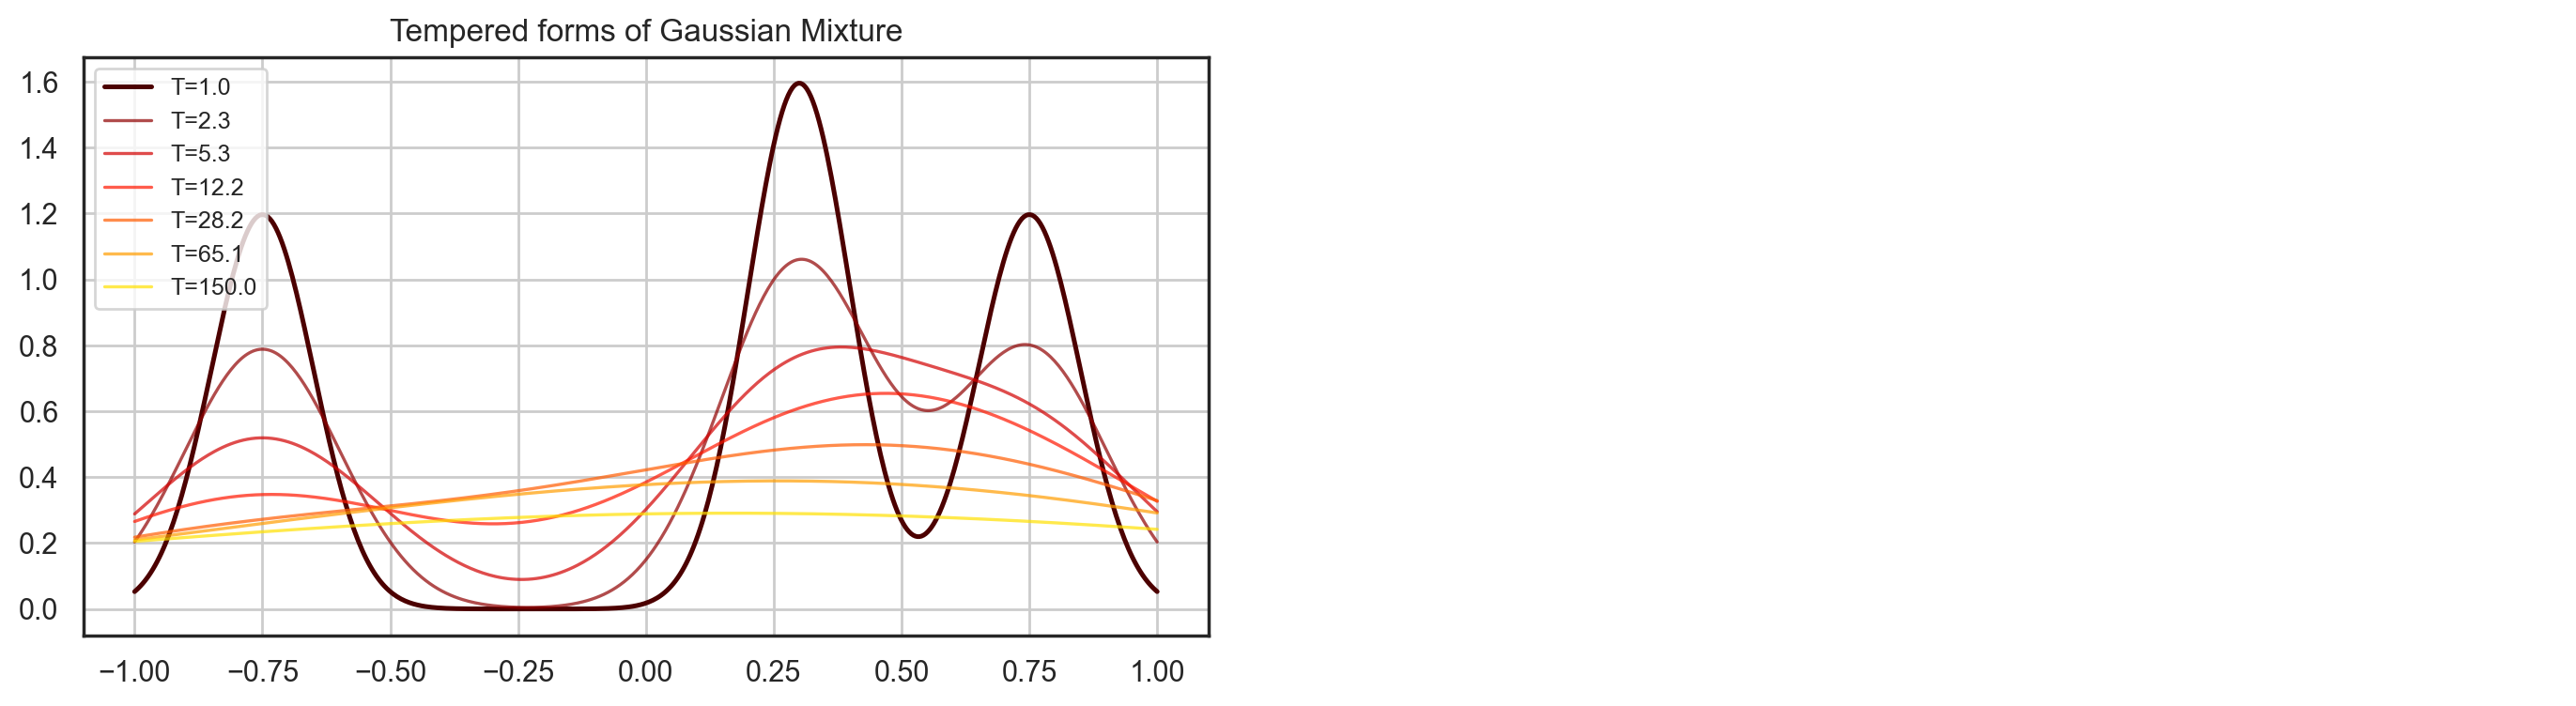

In [2]:
from models.mcmc import TemperredMetropolisHastings # this is where the source code implementation of our Metropolis-Hastings
from models.distributions import gmm_pdf, normal_pdf
from models.step_methods import normal_step_method

# gaussian parameters (same as previous notebook)
weights = np.array([0.3, 0.4, 0.3])
mu = np.array([-0.75, 0.3, 0.75])
sigma = np.array([0.1, 0.1, 0.1])

# Initialie tempered MH sampler
T_max, N = 150, 7
TemperredMH = TemperredMetropolisHastings(
    target_pdf = lambda x, T: gmm_pdf(x, weights=weights, mu=mu, sigma=(np.sqrt(T) * sigma)),
    step_method = lambda mu: normal_step_method(mu, s=0.16),
    proposal_pdf = lambda x,mu: normal_pdf(x, mu, s=0.16),
    temperatures = T_max ** (np.arange(N) / (N - 1))
)

fig, [ax, _] = plt.subplots(ncols=2, nrows=1, figsize=(17,4))
_.axis('off')
colors = plt.cm.hot(np.linspace(0.1,0.7,N))
x = np.linspace(-1,1,500)
for i, chain in enumerate(TemperredMH.chains):
    pdf = chain.target_pdf(x)
    T = chain.temperature
    label = f"T={T:.1f}"
    alpha, lw = (1, 1.8) if T==1 else (0.7, 1.2)
    ax.plot(x, pdf, label=label, alpha=alpha, lw=lw, c=colors[i])
ax.legend(fontsize=9,loc=2)
ax.grid()
ax.set_title("Tempered forms of Gaussian Mixture")
plt.show()

As shown in the figure above, raising the temperature of the temperred $\pi^T$ basically flattens the distribution, allowing the chain to accept states otherwise rejected by the colder chain. This has strong similarities with [Simulated Annealing method discussed in earlier notebook](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/02%20Simulated%20Annealing%20to%20Help%20The%20Salesman.ipynb)

In [3]:
# run the Sampler
tempering_samples = TemperredMH.run(n_samples=10000, start_value=[0,1])
print(f"Finished drawing {len(tempering_samples)} samples\n")

Finished drawing 10000 samples



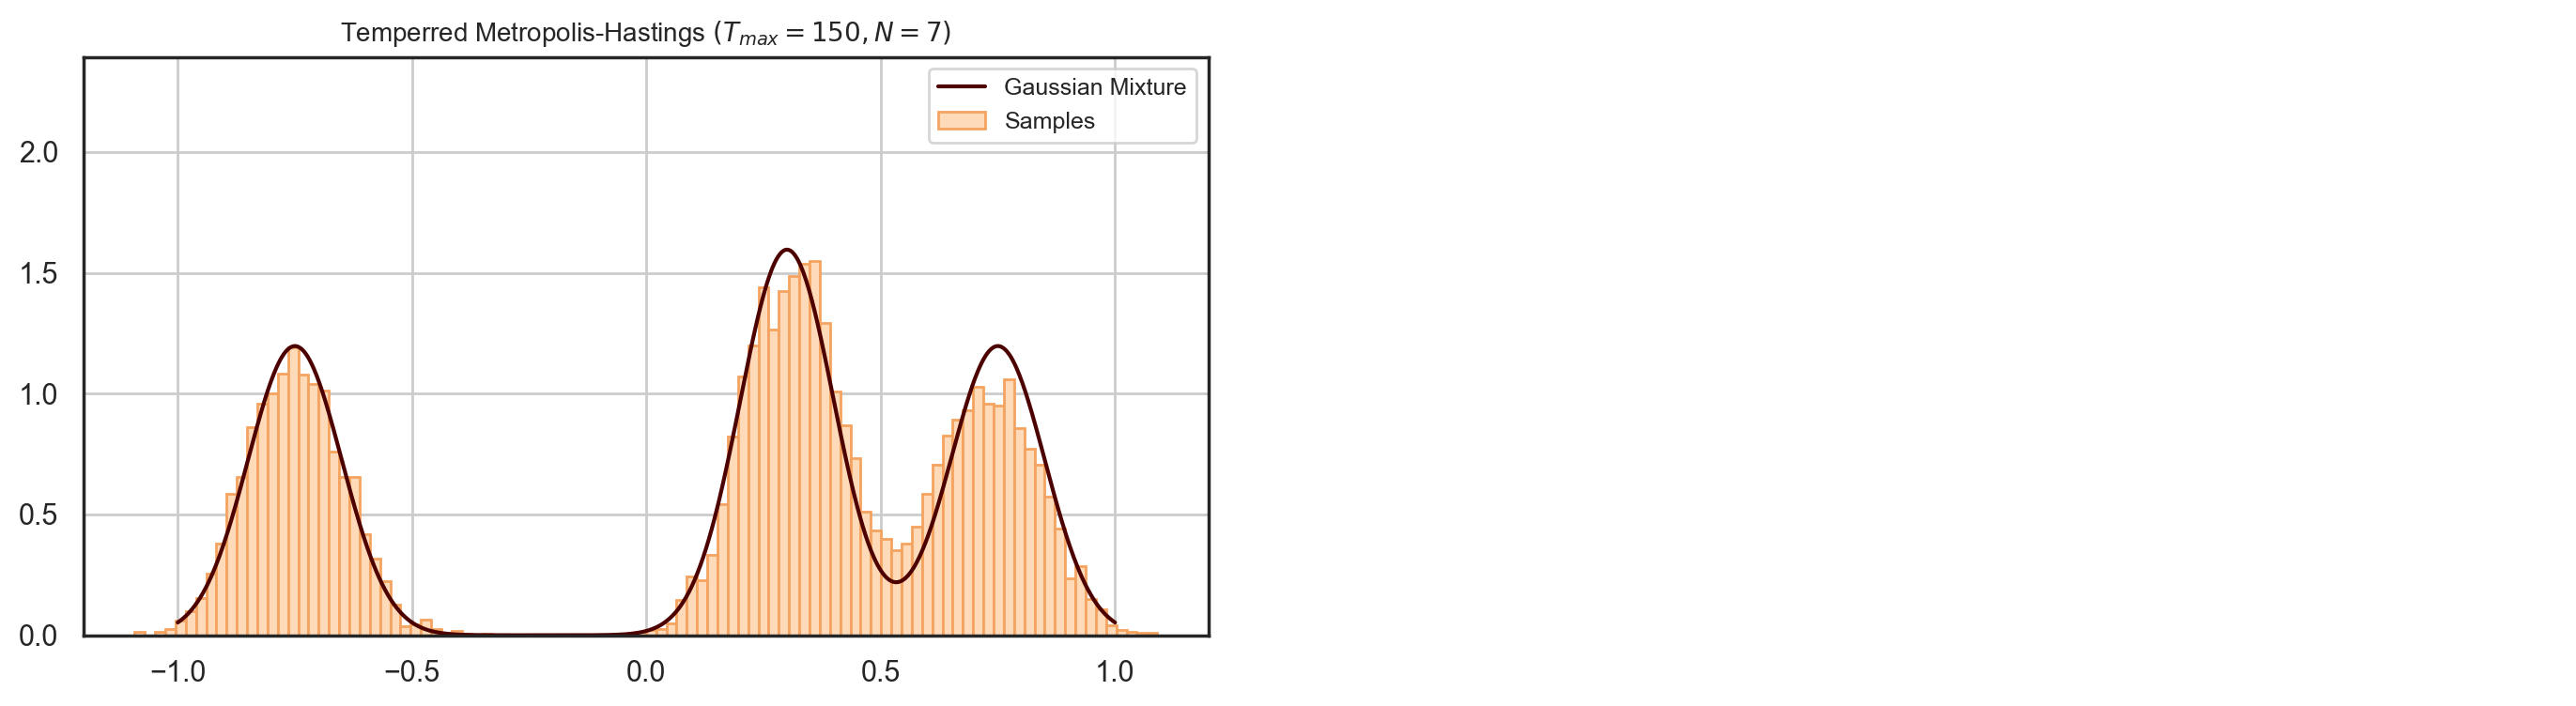

In [6]:
# Visualize the sampling result

x = np.linspace(-1,1,1000)
pdf = gmm_pdf(x, weights=weights, mu=mu, sigma=sigma)
fig, [ax, _] = plt.subplots(ncols=2, nrows=1, figsize=(17,4))
_.axis('off')
ax.plot(x, pdf, label='Gaussian Mixture', c=plt.cm.hot(0.1))
ax.hist(tempering_samples, bins=100, density=True,
        fc='peachpuff', edgecolor='sandybrown',
        label='Samples')
ax.set_title(f'Temperred Metropolis-Hastings $(T_{{max}}={T_max}, N={N})$', fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim([0, max(pdf)*1.5])    
ax.grid()
plt.show()

This result is definitely better than vanilla Metropolis-Hastings from the previous notebook. All regions can be explored more proportionately and the under/over sampling of certain regions are better minimized.

## E. PyMC as Benchmark

[PyMC](https://www.pymc.io/welcome.html) is a popular framework for MCMC and Bayesian Inference. However, it turns out PyMC does not implement parallel tempering under the hood (their default MH sampler [pymc.Metropolis](https://www.pymc.io/projects/docs/en/v5.3.1/api/generated/pymc.Metropolis.html)). On the other hand, parallel tempering is also one of the most popular Metropolis-Hastings optimization method. So it is interesting to compare this implementation of paralel tempering with PyMC.

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x_samples]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


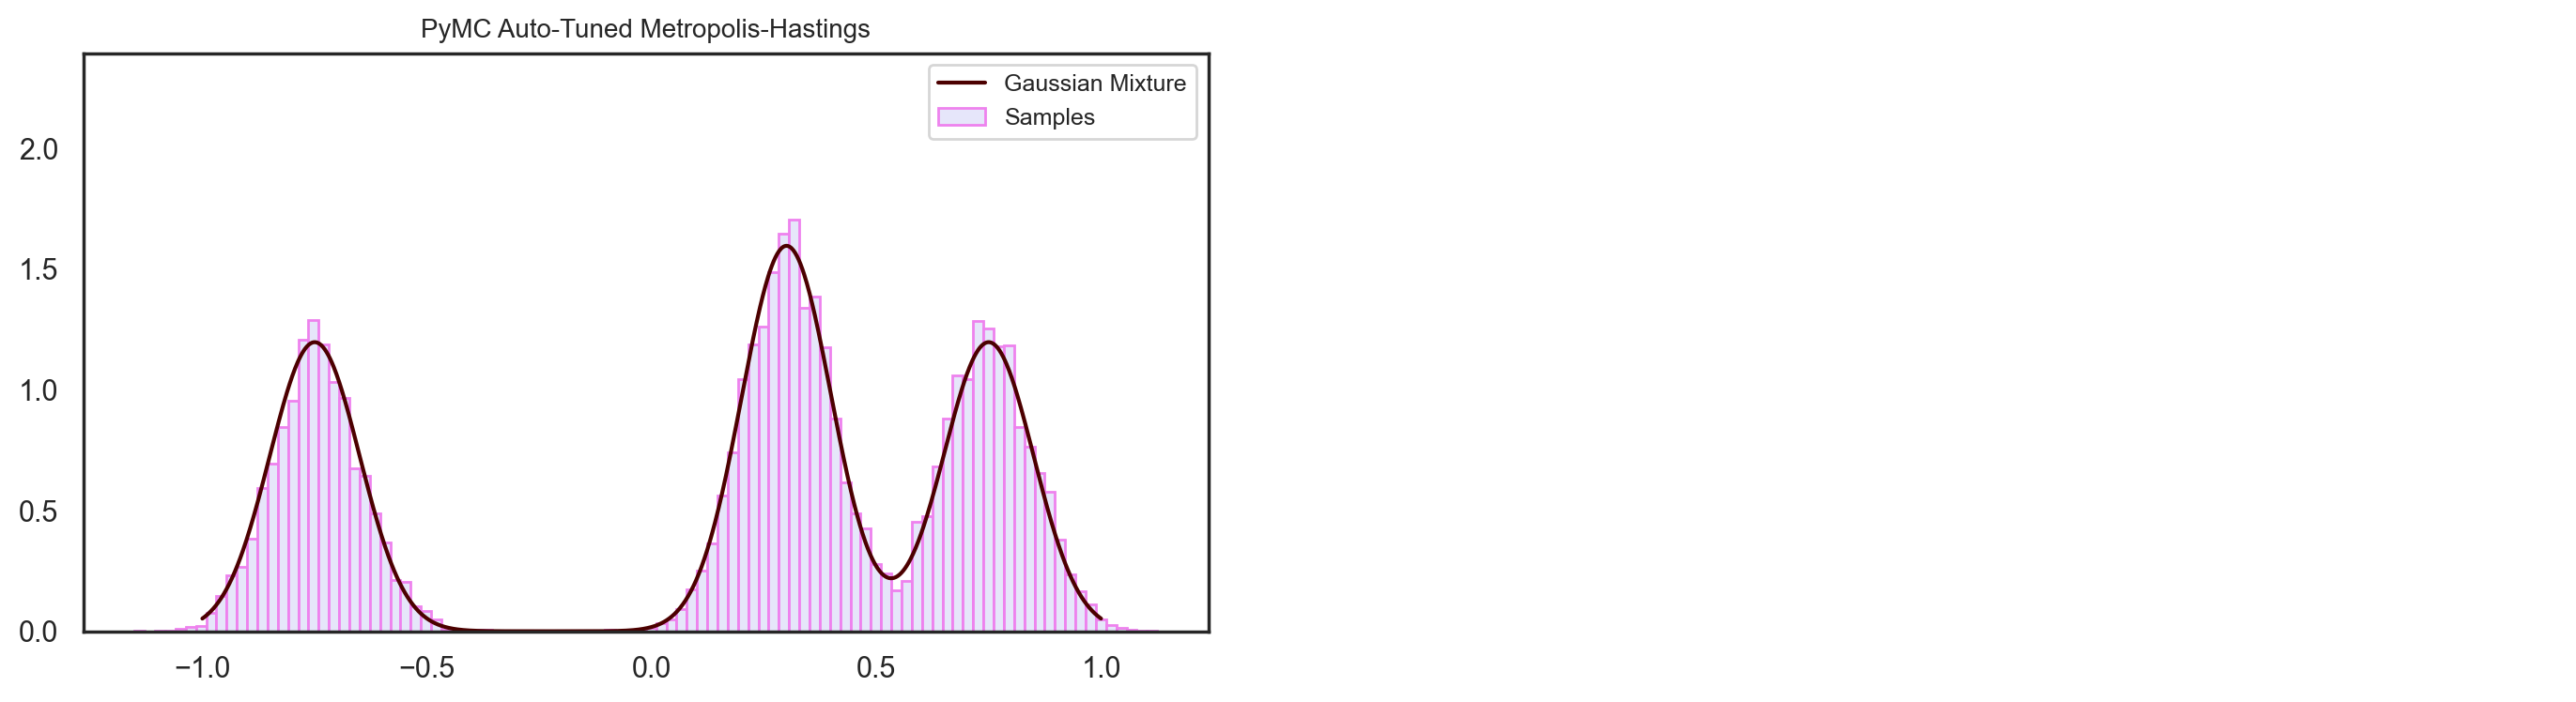

In [5]:
# Sampling using PyMC
import pymc as pm
with pm.Model() as model:
    # GMM as target
    pm.NormalMixture("x_samples", w=weights, mu=mu, sigma=sigma)
    # Use metropolis hastings algorithm
    step_method = pm.Metropolis()
    # Sample from the model (MCMC sampling)
    trace = pm.sample(10000, step=step_method, return_inferencedata=False)
# Access the sampled values from the trace
pymc_samples = trace['x_samples']

# Visualize the sampling results

x = np.linspace(-1,1,1000)
pdf = gmm_pdf(x, weights=weights, mu=mu, sigma=sigma)
fig, [ax, _] = plt.subplots(ncols=2, nrows=1, figsize=(17,4))
_.axis('off')
ax.plot(x, pdf, label='Gaussian Mixture', c=plt.cm.hot(0.1))
ax.hist(pymc_samples, bins=100, density=True,
        fc='lavender', edgecolor='violet',
        label='Samples')
ax.set_title('PyMC Auto-Tuned Metropolis-Hastings', fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim([0, max(pdf)*1.5])    
plt.show()

Wow! not only it's fast, PyMC also produces samples perfectly fit with the target distribution compared to our from-scratch implementation of paralel tempering :(

## F. Reflection

Sampler design is crucial to obtain accurate samples from target distribution. I have learnt from this notebook that designing a sampler can also be done by making replica of chains, each with tempered/flattened form of the original target distribution. This is achieved by introducing temperature parameters that scales the shape parameters of the target distribution ($\sigma$ in case of normal distribution). This method produce better samples compared to vanilla Metropolis-Hastings.

Parallel tempering can be categorized as advance agorithm. However, PyMC outperforms this method despite not using paralel temperring. Of course room for improvement is in my implementation of the algorithm. 

If we dive into the source code of PyMC, we can see that PyMC implement a convergence diagnostic in order to auto-tune the chain. In contrast, I have to manually adjust the parameters ($T_{\text{max}}$, $N$ (number of chains/replicas), $\sigma$ of the proposal distribution, etc.). Not only is difficult to get the best configuration, the parameters are static while the chain can have certain dynamics when given a complex target distribution. PyMC cleverly addresses this problem by making the parameters dynamics along the chain runs.

How to auto-tune the parameters will be a big thing to explore in the next notebooks.

# --- End of notebook ---